In [1]:
import pandas as pd
import numpy as np
import re
import joblib
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("All libraries imported successfully!")

All libraries imported successfully!


Load the cleaned dataset


In [2]:
csv_path = "netflix_titles_cleaned.csv"

df = pd.read_csv(csv_path)
print("Dataset loaded successfully!")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

Dataset loaded successfully!
Shape: (8807, 17)
Columns: ['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description', 'duration_parsed', 'is_movie', 'year_added', 'content_age', 'primary_genre']


Data inspection

In [3]:
print("\nSample of data:")
print(df.head(3))
print("\nMissing values per column:")
print(df.isnull().sum())
print("\nData types:")
print(df.dtypes)


Sample of data:
  show_id     type                 title         director  \
0      s1    Movie  Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show         Blood & Water    Not Specified   
2      s3  TV Show             Ganglands  Julien Leclercq   

                                                cast        country  \
0                                      Not Specified  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...  Not Specified   

   date_added  release_year rating   duration  \
0  2021-09-25          2020  PG-13     90 min   
1  2021-09-24          2021  TV-MA  2 Seasons   
2  2021-09-24          2021  TV-MA   1 Season   

                                           listed_in  \
0                                      Documentaries   
1    International TV Shows, TV Dramas, TV Mysteries   
2  Crime TV Shows, International TV Shows, TV Act...   

                               

Feature Engineering

In [4]:
df_proc = df.copy()

# Extract numeric duration (e.g., "90 min" -> 90)
def extract_duration(x):
    if pd.isna(x):
        return np.nan
    m = re.search(r'(\d+)', str(x))
    return int(m.group(1)) if m else np.nan

if 'duration' in df_proc.columns:
    df_proc['duration_int'] = df_proc['duration'].apply(extract_duration)
else:
    df_proc['duration_int'] = np.nan

# Count number of cast members
if 'cast' in df_proc.columns:
    df_proc['cast_count'] = df_proc['cast'].fillna("").apply(
        lambda s: 0 if s.strip() == "" else len([p for p in s.split(",") if p.strip() != ""])
    )
else:
    df_proc['cast_count'] = 0

# Fill missing important fields
df_proc['director'] = df_proc.get('director', pd.Series(['Unknown']*len(df_proc))).fillna('Unknown')
df_proc['country'] = df_proc.get('country', pd.Series(['Unknown']*len(df_proc))).fillna('Unknown')
df_proc['rating'] = df_proc.get('rating', pd.Series(['Not Rated']*len(df_proc))).fillna('Not Rated')

df_proc['release_year'] = pd.to_numeric(df_proc.get('release_year', pd.Series([np.nan]*len(df_proc))), errors='coerce')

print("Feature engineering completed!")
print("New columns:", ['duration_int', 'cast_count'])

Feature engineering completed!
New columns: ['duration_int', 'cast_count']


Target encoding (Movie vs TV Show)

In [5]:
if 'type' not in df_proc.columns:
    raise ValueError("Dataset does not contain a 'type' column!")

df_proc = df_proc[df_proc['type'].isin(['Movie', 'TV Show'])]
le_target = LabelEncoder()
df_proc['type_label'] = le_target.fit_transform(df_proc['type'])

print("Target encoding completed!")
print("Target mapping:", dict(zip(le_target.classes_, le_target.transform(le_target.classes_))))
print("Class distribution:")
print(df_proc['type'].value_counts())

Target encoding completed!
Target mapping: {'Movie': np.int64(0), 'TV Show': np.int64(1)}
Class distribution:
type
Movie      6131
TV Show    2676
Name: count, dtype: int64


Simplifying categorical columns

In [6]:
# Keep top 10 directors, label others as 'Other'
top_directors = df_proc['director'].value_counts().nlargest(10).index.tolist()
df_proc['director_top'] = df_proc['director'].apply(lambda d: d if d in top_directors else 'Other')

print("Categorical simplification completed!")
print("Top directors:", top_directors)

Categorical simplification completed!
Top directors: ['Not Specified', 'Rajiv Chilaka', 'Raúl Campos, Jan Suter', 'Suhas Kadav', 'Marcus Raboy', 'Jay Karas', 'Cathy Garcia-Molina', 'Martin Scorsese', 'Youssef Chahine', 'Jay Chapman']


Selecting of features and target

In [7]:
feature_cols = ['release_year', 'duration_int', 'cast_count', 'rating', 'country', 'director_top']
X = df_proc[feature_cols]
y = df_proc['type_label']

print("Features and target selected!")
print("Feature columns:", feature_cols)
print("X shape:", X.shape)
print("y shape:", y.shape)

Features and target selected!
Feature columns: ['release_year', 'duration_int', 'cast_count', 'rating', 'country', 'director_top']
X shape: (8807, 6)
y shape: (8807,)


Train/test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train/test split completed!")
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Training set class distribution:")
print(pd.Series(y_train).value_counts())
print("Test set class distribution:")
print(pd.Series(y_test).value_counts())

Train/test split completed!
Train shape: (7045, 6) Test shape: (1762, 6)
Training set class distribution:
type_label
0    4904
1    2141
Name: count, dtype: int64
Test set class distribution:
type_label
0    1227
1     535
Name: count, dtype: int64


Preprocessing pipelines

In [14]:
numeric_features = ['release_year', 'duration_int', 'cast_count']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = ['rating', 'country', 'director_top']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))

])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

print("Preprocessing pipeline created!")
print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

Preprocessing pipeline created!
Numeric features: ['release_year', 'duration_int', 'cast_count']
Categorical features: ['rating', 'country', 'director_top']


Building and training the model

In [15]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200, random_state=42, n_jobs=-1))
])

print("Starting model training...")
clf.fit(X_train, y_train)
print("Model training complete!")

Starting model training...
Model training complete!


Model performance

In [17]:

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=le_target.classes_)
cm = confusion_matrix(y_test, y_pred)

print(f"Model Evaluation Results:")
print(f"Accuracy: {acc:.4f}")
print(f"\nClassification Report:\n{report}")
print(f"Confusion Matrix:\n{cm}")

Model Evaluation Results:
Accuracy: 0.9994

Classification Report:
              precision    recall  f1-score   support

       Movie       1.00      1.00      1.00      1227
     TV Show       1.00      1.00      1.00       535

    accuracy                           1.00      1762
   macro avg       1.00      1.00      1.00      1762
weighted avg       1.00      1.00      1.00      1762

Confusion Matrix:
[[1227    0]
 [   1  534]]


Confusion Matrix Plot

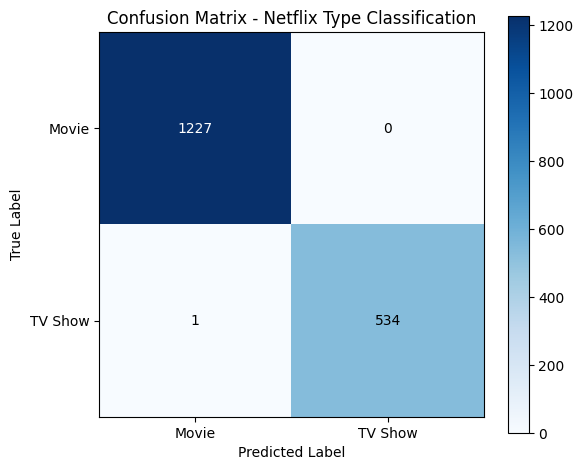

In [18]:
plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix - Netflix Type Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0, 1], le_target.classes_)
plt.yticks([0, 1], le_target.classes_)

# Add text annotations
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

Trained model saved

In [19]:
trained_model_path = "netflix_type_rf_model.pkl"
joblib.dump({'pipeline': clf, 'label_encoder': le_target, 'feature_columns': feature_cols}, trained_model_path)
print(f"Trained model saved to: {trained_model_path}")

# Verify the model can be loaded
loaded_model = joblib.load(trained_model_path)
print("Model verification: Model can be loaded successfully!")

Trained model saved to: netflix_type_rf_model.pkl
Model verification: Model can be loaded successfully!


Verification

In [20]:

sample_pred = clf.predict(X_test[:5])
sample_prob = clf.predict_proba(X_test[:5])

print("Sample Predictions from Test Set:")
print("=" * 50)
for idx, (pred, prob, true) in enumerate(zip(sample_pred, sample_prob, y_test[:5])):
    predicted_label = le_target.inverse_transform([pred])[0]
    true_label = le_target.inverse_transform([true])[0]
    confidence = prob.max()
    print(f"Row {idx+1}: True: {true_label} | Predicted: {predicted_label} | Confidence: {confidence:.3f}")

Sample Predictions from Test Set:
Row 1: True: Movie | Predicted: Movie | Confidence: 1.000
Row 2: True: Movie | Predicted: Movie | Confidence: 0.995
Row 3: True: Movie | Predicted: Movie | Confidence: 1.000
Row 4: True: Movie | Predicted: Movie | Confidence: 0.800
Row 5: True: Movie | Predicted: Movie | Confidence: 0.905


Feature Importance Analysis

Top 10 Most Important Features:
                        feature  importance
1                  duration_int    0.389819
665  director_top_Not Specified    0.252289
666          director_top_Other    0.231894
2                    cast_count    0.019171
0                  release_year    0.018566
12                     rating_R    0.010027
229               country_India    0.008315
390         country_South Korea    0.006495
11                 rating_PG-13    0.005587
288               country_Japan    0.004099


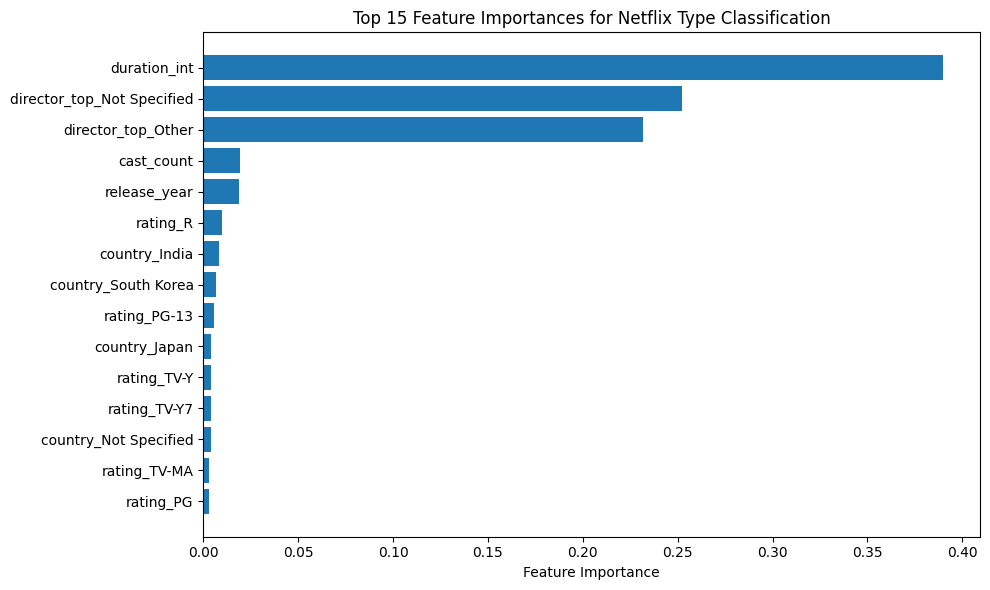

In [21]:

# Extract feature names from preprocessor
feature_names = (numeric_features + 
                list(clf.named_steps['preprocessor']
                    .named_transformers_['cat']
                    .named_steps['onehot']
                    .get_feature_names_out(categorical_features)))

# Get feature importances from the Random Forest
importances = clf.named_steps['classifier'].feature_importances_

# Create feature importance dataframe
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print("=" * 40)
print(feature_importance_df.head(10))

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df.head(15)['feature'], 
         feature_importance_df.head(15)['importance'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances for Netflix Type Classification')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [24]:

print("Model Deployment Summary:")
print("=" * 40)
print(f"✅ Model Type: Random Forest Classifier")
print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ Features Used: {len(feature_cols)}")
print(f"✅ Training Samples: {X_train.shape[0]}")
print(f"✅ Test Samples: {X_test.shape[0]}")
print(f"✅ Model Saved: {trained_model_path}")
print(f"✅ Target Classes: {list(le_target.classes_)}")

Model Deployment Summary:
✅ Model Type: Random Forest Classifier
✅ Accuracy: 0.9994
✅ Features Used: 6
✅ Training Samples: 7045
✅ Test Samples: 1762
✅ Model Saved: netflix_type_rf_model.pkl
✅ Target Classes: ['Movie', 'TV Show']
